In [1]:
import torch, torchvision
from ffcv.writer import DatasetWriter
from typing import List
from ffcv.fields import IntField, RGBImageField
from ffcv.loader import Loader, OrderOption
from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
from ffcv.pipeline.operation import Operation
from ffcv.transforms import RandomHorizontalFlip, Cutout, \
    RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage, NormalizeImage
from ffcv.transforms.common import Squeeze
from munch import DefaultMunch
import json
import danns_eg.resnets as resnets
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.ndimage import gaussian_filter
from danns_eg.conv import EiConvLayer, ConvLayer

/home/mila/r/roy.eyono/.conda/envs/ffcv_eg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mila/r/roy.eyono/.conda/envs/ffcv_eg/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_cifar_dataloaders():
    # assumes beton files on slurm? 
    CIFAR_MEAN = [125.307, 122.961, 113.8575]
    CIFAR_STD = [51.5865, 50.847, 51.255]
    #if p.data.subtract_mean == False:
    CIFAR_MEAN = [0.0, 0.0, 0.0]
    #    print("Info: not subtracting the mean!")

    test_dataset= "/network/projects/_groups/linclab_users/ffcv/ffcv_datasets/cifar10/test.beton"
    paths = {
        'test': test_dataset
    }
    loaders = {}
    for name in ['test']:
        label_pipeline: List[Operation] = [IntDecoder(), ToTensor(), ToDevice('cuda:0'), Squeeze()]
        image_pipeline: List[Operation] = [SimpleRGBImageDecoder()]
        image_pipeline.extend([
            ToTensor(),
            ToDevice('cuda:0', non_blocking=True),
            ToTorchImage(),
            Convert(torch.float16),
            torchvision.transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
        ])
        # if not p.exp.use_autocast: Convert(torch.float32),
        # getting error RuntimeError: result type Float can't be cast to the desired output type Byte
    
        ordering = OrderOption.RANDOM if name == 'train' else OrderOption.SEQUENTIAL

        loaders[name] = Loader(paths[name], batch_size=32, 
                               num_workers=4,
                               order=ordering, 
                               drop_last=(name == 'train'),
                               pipelines={'image': image_pipeline, 'label': label_pipeline})

    return loaders

In [3]:
loaders = get_cifar_dataloaders()

In [4]:
X,y = next(iter(loaders['test']))

In [33]:
layer = '6'
accs = {}
mu = {}
std = {}

plt.figure(figsize=(10, 6))

prev_hist = None

# kl_plot = []

for lambda_homeo in [0.0, 1e-2, 1e-1, 1e2, 1e4]:
    accs[lambda_homeo] = {}
    activation = {}
    mu[lambda_homeo] = {}
    std[lambda_homeo] = {}
    for lambda_var in [0.0, 1e-2, 1e-1, 1e2, 1e4]:
        
        try:
            with open(f'notebooks/saved_models/ex2_lambda_fixedWee_70per_inh/model_resnet9_lr_0.1_wd_0.001_m_0.9_norm_ln_epochs_50_seed_5_lagrangian_True_lambda_mu_{lambda_homeo}_lambda_var_{lambda_var}.json', 'r') as f:
                model_json = json.load(f)
        except FileNotFoundError:
            print(f"not found: {lambda_homeo}, {lambda_var}")
            continue
        
        mu[lambda_homeo][lambda_var] = np.array([])
        std[lambda_homeo][lambda_var] = np.array([])
        for epoch in ["0", "10", "20", "30", "40", "50"]:
            # Load model weights
            cfg = DefaultMunch.fromDict(model_json)
            model = resnets.resnet9_kakaobrain(cfg)
            if epoch != "0":
                model.load_state_dict(torch.load(f'notebooks/saved_models/ex2_lambda_fixedWee_70per_inh/model_resnet9_lr_0.1_wd_0.001_m_0.9_norm_ln_epochs_50_seed_5_lagrangian_True_lambda_mu_{lambda_homeo}_lambda_var_{lambda_var}_epoch_{epoch}.pt'))

            with autocast():
                all_modules = list(model.modules())
                module = all_modules[1]
                # Simulate step-by-step forward computation
                output_data = X
                if isinstance(module, torch.nn.Module):
                    if isinstance(module, torch.nn.ModuleDict):
                        for layer_name, layer_idx in module.items():
                            if hasattr(layer_idx, "__getitem__"):
                                pre_output_data = layer_idx[0](output_data)
                                activation[layer_name] = pre_output_data
                                output_data = layer_idx(output_data)
                            else:
                                output_data = layer_idx(output_data)
                                #activation[layer_name] = output_data
            
            
            activation_data = activation[layer]
            # print(activation_data.shape)
            filtered_avg = activation_data[0].reshape(1,-1) # Only taking the first element in the first batch
            # print(filtered_avg.shape)
            filtered_avg = filtered_avg.detach().cpu().numpy()
            
            #print(filtered_avg.shape)
            is_inf = np.isinf(filtered_avg)

            # Check for "nan" values
            is_nan = np.isnan(filtered_avg)

            

            

            #print(f'Lambda ({lambda_homeo}), Epoch: {epoch}, mean: {filtered_avg.mean(1)}, std: {filtered_avg.std(1, dtype=np.float64)}')
            mu[lambda_homeo][lambda_var] = np.append(mu[lambda_homeo][lambda_var], filtered_avg.mean(1))
            std[lambda_homeo][lambda_var] = np.append(std[lambda_homeo][lambda_var], filtered_avg.std(1, dtype=np.float64))

            filtered_avg = filtered_avg.mean(axis=0) #.flatten()
            # print(filtered_avg.shape)
            # print(min(filtered_avg), max(filtered_avg))

            
            
            # dta = activation_data[:,filter].flatten().detach().cpu().numpy()

            # sigma = np.std(dta)  # Adjust the standard deviation as needed

            sigma = 0.01

            # Generate additional data with a long-tailed distribution (e.g., exponential)
            #long_tail_data = np.random.exponential(scale=5, size=500)

            # Combine the original data and the long-tailed data
            #dta = np.concatenate((dta, long_tail_data))

            # hist, bin_edges = np.histogram(filtered_avg, bins=15)
            # Apply a Gaussian filter to the histogram
            
            # smoothed_hist = gaussian_filter(hist, sigma)
            # plt.hist(smoothed_hist, bins=15, histtype='step', alpha=1, label=f'Epoch {epoch}', linewidth=5)
            # plt.hist(bin_edges[:-1], bin_edges, weights = smoothed_hist, histtype='step', alpha=0.5, label=f'Epoch {epoch}', linewidth=5)

            # if prev_hist is None:
            #     kl_plot.append(0)
            #     prev_hist = hist
            # else:
            #     kl_plot.append(kl(hist, prev_hist))
            #     prev_hist = hist
        accs[lambda_homeo][lambda_var] = cfg.res.test_accs

# plt.title(f'Layer {layer}')
# plt.yscale('log')
# plt.xlabel('Activation Values')
# plt.ylabel('Frequency')
# #plt.xlim([0.2,1])
# plt.legend()
# #plt.grid(True)
# plt.show()

<Figure size 1000x600 with 0 Axes>

In [7]:
mu[0.0][0.0]

array([0.04251099, 0.09051514, 0.12225342, 0.14355469, 0.14990234])

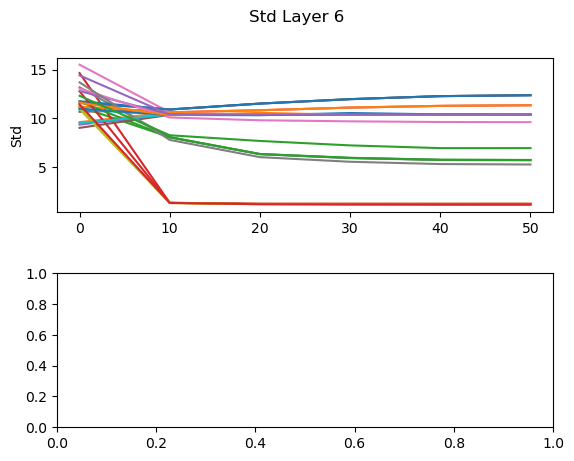

In [50]:
fig, axs = plt.subplots(2)
fig.suptitle(f'Std Layer {layer}')
mean_threshold = 20
width = 0.1
itemx = 0
fig.subplots_adjust(hspace=0.4)
for lambda_homeo in [0.0, 1e-2, 1e-1, 1e2, 1e4]:
    for lambda_var in [0.0, 1e-2, 1e-1, 1e2, 1e4]:
        if not lambda_homeo in mu:
            continue
        else:
            if not lambda_var in mu[lambda_homeo]:
                continue
        mean = np.mean(mu[lambda_homeo][lambda_var])
        variance = np.mean(std[lambda_homeo][lambda_var])
        if mean < mean_threshold and mean > - mean_threshold:
            #if variance < mean_threshold - 1 and variance > 1 - mean_threshold:
            #axs[0].errorbar(np.arange(len(mu[lambda_homeo][lambda_var])), mu[lambda_homeo][lambda_var], yerr=std[lambda_homeo][lambda_var], fmt='-,', label = f'mu: {lambda_homeo} , std: {lambda_var}')
            axs[0].plot(["0","10","20","30","40","50"],std[lambda_homeo][lambda_var], label = f'mu: {lambda_homeo} , std: {lambda_var}')
            axs[0].set_ylabel('Std')
            #axs[0].legend(bbox_to_anchor=(1.5, 0.8))
            # axs[1].bar(np.arange(len(std[lambda_homeo][lambda_var])) + (width*itemx), std[lambda_homeo][lambda_var], width, label = f'mu: {lambda_homeo} , std: {lambda_var}')
            # axs[1].legend(bbox_to_anchor=(1.5, 0.8))
            # axs[1].set_ylabel('Std')
            # axs[2].bar(np.arange(len(mu[lambda_homeo][lambda_var])) + (width*itemx), mu[lambda_homeo][lambda_var], width)
            # axs[2].set_ylabel('Mean')
            # axs[1].plot(accs[lambda_homeo][lambda_var])
            # axs[1].set_ylabel('Acc')
            # axs[1].plot(plt.xlim(),[89.1,89.1],'k--')
            # axs[1].plot(plt.xlim(),[86.7,86.7],'k--')
            # axs[1].set_ylim(86,92)
            # axs[1].set_xlim(40,50)
            #axs[3].set_xlim(0,50)
            #axs[3].set_yscale('log')
            #itemx+=1


In [20]:
hyperparam = np.array([0, 1e-2, 1e-1, 1e2, 1e4])
heatmap_acc = np.zeros((len(hyperparam), len(hyperparam)))
heatmap_mean = np.zeros((len(hyperparam), len(hyperparam)))
heatmap_std = np.zeros((len(hyperparam), len(hyperparam)))
for idx, lambda_homeo in enumerate(hyperparam):
    for idy, lambda_var in enumerate(hyperparam):
        if not lambda_homeo in mu:
            heatmap_acc[idx][idy] = 0
            heatmap_mean[idx][idy] = -100
            heatmap_std[idx][idy] = 100
            continue
        else:
            if not lambda_var in mu[lambda_homeo]:
                heatmap_acc[idx][idy] = 0
                heatmap_mean[idx][idy] = -100
                heatmap_std[idx][idy] = 100
                continue
        heatmap_acc[idx][idy] = max(accs[lambda_homeo][lambda_var])
        heatmap_mean[idx][idy] = np.mean(mu[lambda_homeo][lambda_var][2:])
        heatmap_std[idx][idy] = np.mean(std[lambda_homeo][lambda_var][2:])

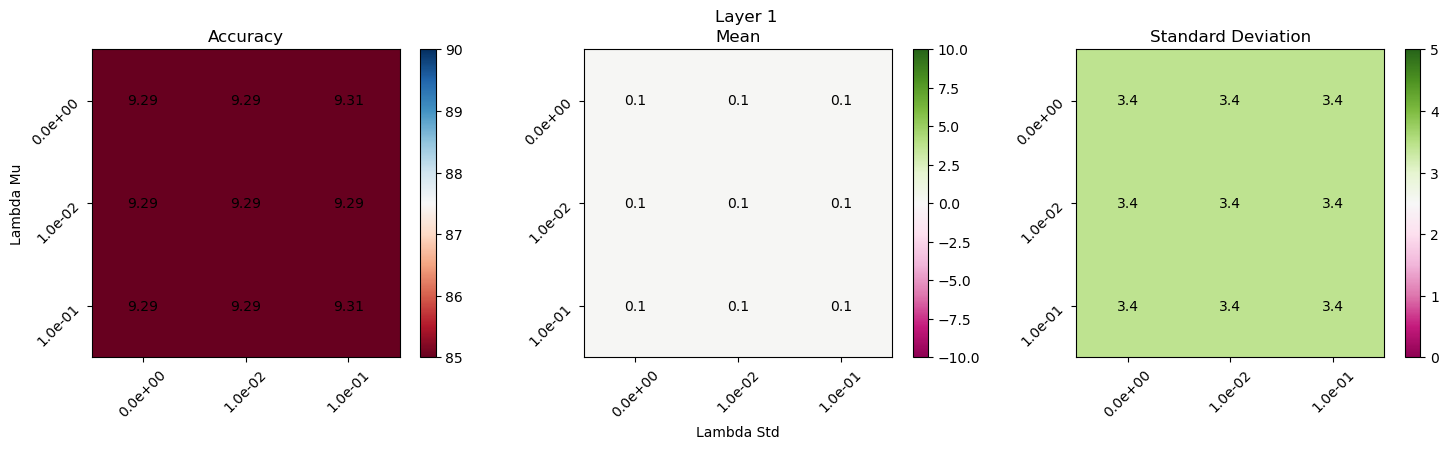

In [21]:
plt.figure(figsize=(18, 4))
plt.suptitle(f'Layer {layer}')


# Subplot 1 (left)
plt.subplot(1, 3, 1)  # 1 row, 2 columns, and this is the first subplot

plt.subplots_adjust(hspace=0.4)
plt.imshow(heatmap_acc, cmap='RdBu', vmin=85, vmax=90)
#plt.xticks(hyperparam)
# Define custom x-axis ticks and labels
custom_xticks = np.arange(len(hyperparam))  # Replace with your desired tick positions
hyperparam_str = ['{:.1e}'.format(number) for number in hyperparam]
custom_xtick_labels = hyperparam_str  # Replace with your desired labels

# Set the custom ticks and labels
plt.title("Accuracy")
#plt.xlabel("Lambda Variance")
plt.ylabel("Lambda Mu")
plt.xticks(custom_xticks, custom_xtick_labels, rotation=45)
plt.yticks(custom_xticks, custom_xtick_labels, rotation=45)
# Add values as text labels
for i in range(heatmap_acc.shape[0]):
    for j in range(heatmap_acc.shape[1]):
        text = plt.text(j, i, f'{heatmap_acc[i][j]:.2f}', ha='center', va='center', color='black')
plt.colorbar()
fig.show()

# Subplot 1 (left)
plt.subplot(1, 3, 2)  # 1 row, 2 columns, and this is the first subplot

plt.subplots_adjust(hspace=0.4)
plt.imshow(heatmap_mean, cmap='PiYG', vmin=-10, vmax=10)
#plt.xticks(hyperparam)
# Define custom x-axis ticks and labels
custom_xticks = np.arange(len(hyperparam))  # Replace with your desired tick positions
#hyperparam_str = ['{:.1e}'.format(number) for number in hyperparam]
custom_xtick_labels = hyperparam_str  # Replace with your desired labels

# Set the custom ticks and labels
plt.title("Mean")
plt.xlabel("Lambda Std")

#plt.ylabel("Lambda Mean")
plt.xticks(custom_xticks, custom_xtick_labels, rotation=45)
plt.yticks(custom_xticks, custom_xtick_labels, rotation=45)
# Add values as text labels
for i in range(heatmap_mean.shape[0]):
    for j in range(heatmap_mean.shape[1]):
        text = plt.text(j, i, f'{heatmap_mean[i][j]:.1f}', ha='center', va='center', color='black')
plt.colorbar()
fig.show()


# Subplot 1 (left)
plt.subplot(1, 3, 3)  # 1 row, 2 columns, and this is the first subplot

plt.subplots_adjust(hspace=0.4)
plt.imshow(heatmap_std, cmap='PiYG', vmin=0, vmax=5)
#plt.xticks(hyperparam)
# Define custom x-axis ticks and labels
custom_xticks = np.arange(len(hyperparam))  # Replace with your desired tick positions
#hyperparam_str = ['{:.1e}'.format(number) for number in hyperparam]
custom_xtick_labels = hyperparam_str  # Replace with your desired labels

# Set the custom ticks and labels
plt.title("Standard Deviation")
#plt.xlabel("Lambda Variance")
#plt.ylabel("Lambda Mean")
plt.xticks(custom_xticks, custom_xtick_labels, rotation=45)
plt.yticks(custom_xticks, custom_xtick_labels, rotation=45)
# Add values as text labels
for i in range(heatmap_std.shape[0]):
    for j in range(heatmap_std.shape[1]):
        text = plt.text(j, i, f'{heatmap_std[i][j]:.1f}', ha='center', va='center', color='black')
plt.colorbar()
fig.show()

Text(0, 0.5, 'Test Loss')

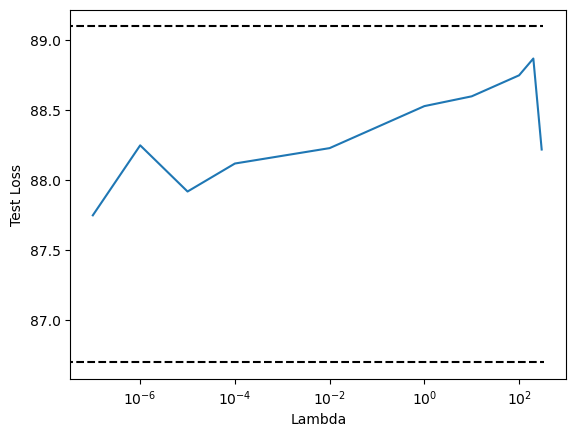

In [20]:
# for k in accs.keys():
#     if k == 1e-3:
#         continue
plt.plot(accs.keys(), [max(accs[k]) for k in accs.keys()])
plt.plot(plt.xlim(),[89.1,89.1],'k--')
plt.plot(plt.xlim(),[86.7,86.7],'k--')
# plt.plot(accs[100.0])
# plt.legend()
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Test Loss')
#plt.xlim(1e-7)

Text(0, 0.5, 'KL Divergence')

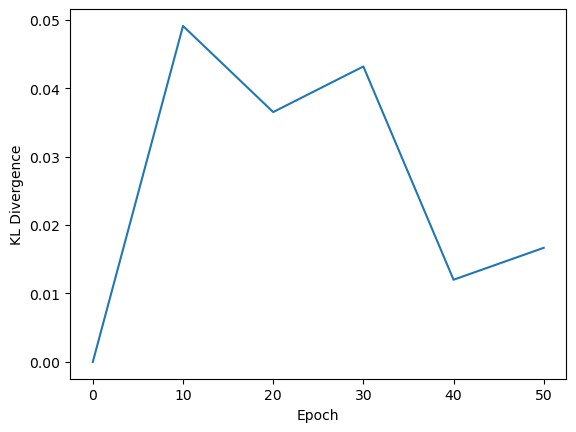

In [24]:
plt.plot(['0', '10','20', '30', '40', '50'],kl_plot)
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')

TODO:

- Two lambdas
- Task that has more a stark dynamic range: make task harder or prune the network
- Area over the curve for accuracy or area under the curve for loss
- Train a DANN with stationary inhib weights aka lambda = 0
- lambda = 0 + Explicit LayerNorm




Text(0, 0.5, 'KL Divergence - No Norm')

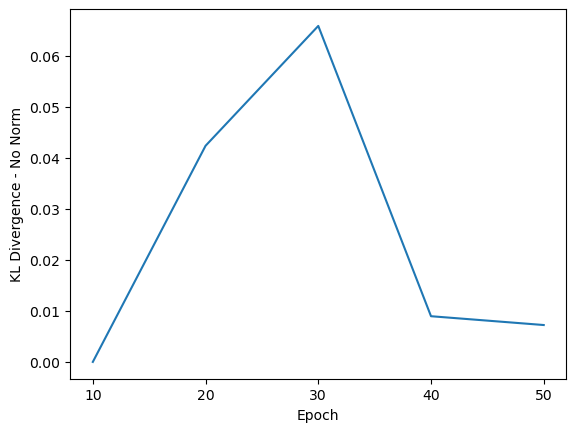

In [92]:
plt.plot(['10','20', '30', '40', '50'],kl_plot)
plt.xlabel('Epoch')
plt.ylabel('KL Divergence - No Norm')

Text(0, 0.5, 'KL Divergence - Approx LN')

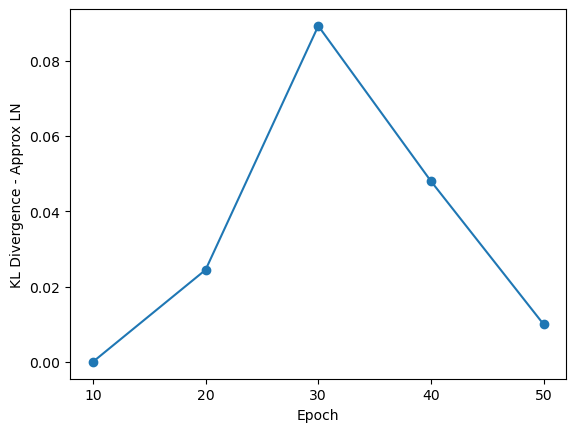

In [95]:
plt.plot(['10','20', '30', '40', '50'],kl_plot, marker='o')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence - Approx LN')

Things to do:

- Average this across multiple seeds/models
- For the 10th epoch, compare against initialization
- Superimpose the KL divergence plots across models

In [5]:
y.shape

torch.Size([32])

In [18]:
# model_resnet50_lr_0.1_wd_0.0001_m_0.9_norm_ln_epochs_50_seed_0_lagrangian_True
# model_resnet9_lr_0.1_wd_1e-06_m_0.9_norm_None_epochs_50_seed_5_lagrangian_False.json
with open('notebooks/saved_models/model_resnet9_lr_0.1_wd_1e-06_m_0.9_norm_ln_epochs_50_seed_5_lagrangian_False.json', 'r') as f:
    model_json = json.load(f)
# Load model weights
cfg = DefaultMunch.fromDict(model_json)
model = resnets.resnet9_kakaobrain(cfg)
model.load_state_dict(torch.load('notebooks/saved_models/model_resnet9_lr_0.1_wd_1e-06_m_0.9_norm_ln_epochs_50_seed_5_lagrangian_False_epoch_50.pt'))

<All keys matched successfully>

In [3]:
for name, param in model.named_parameters():
    print(name)

module_dict.0.module_dict.0.local_loss_multiplier
module_dict.0.module_dict.0.local_loss_value
module_dict.0.module_dict.0.Wex
module_dict.0.module_dict.0.Wix
module_dict.0.module_dict.0.Wei
module_dict.0.module_dict.0.norm_layer.weight
module_dict.0.module_dict.0.norm_layer.bias
module_dict.0.module_dict.1.weight
module_dict.0.module_dict.1.bias
module_dict.1.module_dict.0.local_loss_multiplier
module_dict.1.module_dict.0.local_loss_value
module_dict.1.module_dict.0.Wex
module_dict.1.module_dict.0.Wix
module_dict.1.module_dict.0.Wei
module_dict.1.module_dict.0.norm_layer.weight
module_dict.1.module_dict.0.norm_layer.bias
module_dict.1.module_dict.1.weight
module_dict.1.module_dict.1.bias
module_dict.2.module.module_dict.0.module_dict.0.local_loss_multiplier
module_dict.2.module.module_dict.0.module_dict.0.local_loss_value
module_dict.2.module.module_dict.0.module_dict.0.Wex
module_dict.2.module.module_dict.0.module_dict.0.Wix
module_dict.2.module.module_dict.0.module_dict.0.Wei
module

In [186]:
activation = {}

In [187]:
with autocast():
    all_modules = list(model.modules())
    module = all_modules[1]
    # Simulate step-by-step forward computation
    output_data = X
    if isinstance(module, torch.nn.Module):
        if isinstance(module, torch.nn.ModuleDict):
            for layer_name, layer in module.items():
                output_data = layer(output_data)
                activation[layer_name] = output_data
                #print(f"{output_data.shape}")
#h1.remove()

In [188]:
# Layers of interest should be layer 1, layer 3, and layer 6
activation.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

In [189]:
activation['1'].shape

torch.Size([32, 128, 16, 16])

torch.Size([32, 128, 6, 6])


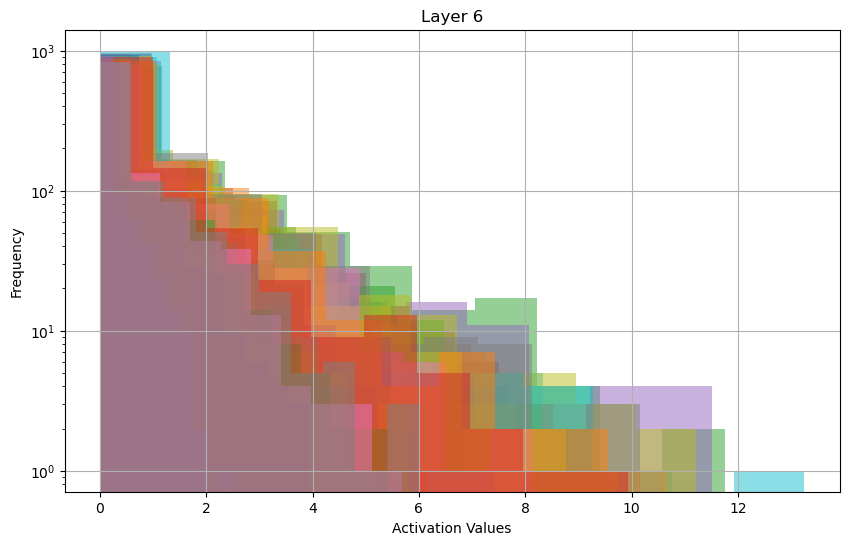

In [196]:
# Create histograms of activation statistics
plt.figure(figsize=(10, 6))
layer = '6'
activation_data = activation[layer] # Only taking the first batch
print(activation_data.shape)
for i in range(activation_data.shape[1]):
    # here we generate a histogram for each channel
    # print(activation_data[:,i].shape)
    plt.hist(activation_data[:,i].flatten().detach().cpu().numpy(), bins=10, alpha=0.5, label=f'Channel {i}')
plt.title(f'Layer {layer}')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Activation Values')
plt.ylabel('Frequency')
#plt.legend()
plt.grid(True)
plt.show()

In [18]:
print(cfg)

DefaultMunch(None, {'train': DefaultMunch(None, {'dataset': 'cifar10', 'batch_size': 512, 'epochs': 50, 'seed': 5, 'use_testset': True}), 'data': DefaultMunch(None, {'subtract_mean': False}), 'model': DefaultMunch(None, {'name': 'resnet9', 'normtype': 'None', 'is_dann': True, 'n_outputs': 10, 'homeostasis': False}), 'opt': DefaultMunch(None, {'algorithm': 'SGD', 'exponentiated': False, 'wd': 1e-06, 'momentum': 0.9, 'lr': 0.1, 'use_sep_inhib_lrs': True, 'use_sep_bias_gain_lrs': False, 'eg_normalise': False, 'nesterov': False, 'inhib_lrs': DefaultMunch(None, {'wei': 0.0001, 'wix': 0.001})}), 'exp': DefaultMunch(None, {'ckpt_dir': '/home/mila/r/roy.eyono/danns_eg/scale_exps/checkpoints', 'num_workers': 4, 'use_autocast': True, 'log_interval': 1, 'data_dir': '', 'use_wandb': False, 'wandb_project': '', 'wandb_entity': 'project_danns', 'wandb_tag': 'default', 'save_results': False, 'save_model': True})})


In [14]:
model

Sequential(
  (module_dict): ModuleDict(
    (0): Sequential(
      (module_dict): ModuleDict(
        (0): EiConvLayer torch.Size([64, 3, 3, 3])
        (1): ReLU(inplace=True)
      )
    )
    (1): Sequential(
      (module_dict): ModuleDict(
        (0): EiConvLayer torch.Size([128, 64, 5, 5])
        (1): ReLU(inplace=True)
      )
    )
    (2): BasicBlock(
      (module): Sequential(
        (module_dict): ModuleDict(
          (0): Sequential(
            (module_dict): ModuleDict(
              (0): EiConvLayer torch.Size([128, 128, 3, 3])
              (1): ReLU(inplace=True)
            )
          )
          (1): Sequential(
            (module_dict): ModuleDict(
              (0): EiConvLayer torch.Size([128, 128, 3, 3])
              (1): ReLU(inplace=True)
            )
          )
        )
      )
    )
    (3): Sequential(
      (module_dict): ModuleDict(
        (0): EiConvLayer torch.Size([256, 128, 3, 3])
        (1): ReLU(inplace=True)
      )
    )
    (4): MaxP

In [17]:
with autocast():
        all_modules = list(model.modules())
        module = all_modules[1]
        # Simulate step-by-step forward computation
        output_data = X
        if isinstance(module, torch.nn.Module):
            if isinstance(module, torch.nn.ModuleDict):
                for layer_name, layer_idx in module.items():
                    print(layer_idx[0])
                    output_data = layer_idx[0](output_data)

EiConvLayer torch.Size([64, 3, 3, 3])
EiConvLayer torch.Size([128, 64, 5, 5])


TypeError: 'BasicBlock' object is not subscriptable